In [ ]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import gdal
import rasterio
# from loss import bce_dice_loss,dice_coef

['2021-11-16 4:23:29', '2021-11-18 4:13:36', '2021-11-21 4:23:31', '2021-11-23 4:13:32', '2021-11-28 4:13:35', '2021-12-01 4:23:31', '2021-12-03 4:13:31', '2021-12-06 4:23:26', '2021-12-08 4:13:34', '2021-12-11 4:23:30', '2021-12-13 4:13:30', '2021-12-16 4:23:25', '2021-12-18 4:13:36', '2021-12-21 4:23:32', '2021-12-23 4:13:30', '2021-12-26 4:23:26', '2021-12-28 4:13:37', '2022-01-02 4:13:31', '2022-01-05 4:23:27', '2022-01-07 4:13:37', '2022-01-10 4:23:32', '2022-01-17 4:13:36', '2022-01-20 4:23:31', '2022-01-22 4:13:30', '2022-01-25 4:23:25', '2022-01-27 4:13:35', '2022-02-01 4:13:30', '2022-02-04 4:23:25', '2022-02-09 4:23:30', '2022-02-14 4:23:25', '2022-02-21 4:13:30', '2022-02-24 4:23:26', '2022-02-26 4:13:38', '2022-03-01 4:23:34', '2022-03-03 4:13:32', '2022-03-06 4:23:28']
[0 1]
[765 171]
(36, 936)
Shape of X (36, 936)
Shape of label y (936,)


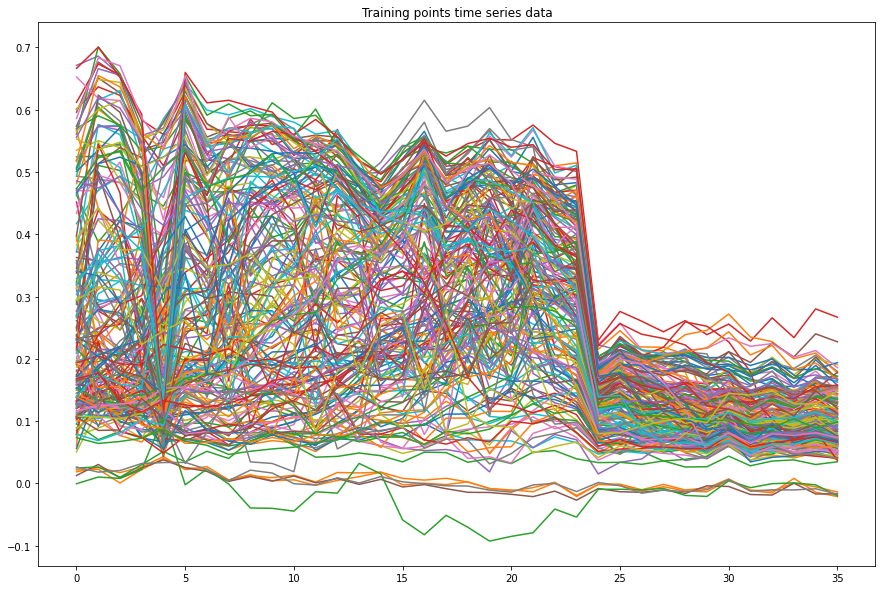

In [ ]:
#Retraining Model
import pandas as pd
train_pts = pd.read_csv('/content/GEE_2_Model_pipeline_2.csv')

# shuffle the DataFrame rows
train_pts = train_pts.sample(frac = 1)
bands = train_pts.columns.to_list()
bands = bands[1:-1]
print(bands)

# Creating training Dataset
data = train_pts[bands].T.interpolate().values
x=[]
x.append(data.T)

# Creating Label Dataset
y = train_pts['label'].values

# print(len(x))
# print(len(y))
print(np.unique(y))
print(np.bincount(y))

import matplotlib.pyplot as plt
# Plotting out training dataset
x_t = np.transpose(np.squeeze(np.asarray(x)))
print(x_t.shape)
plt.figure(figsize=(15,10))
plt.plot(x_t[:,:200]);
# plt.plot(x_t);
plt.title('Training points time series data');


print('Shape of X',x_t.shape)
print('Shape of label y',y.shape)

x_t = np.moveaxis(x_t,0,1)

# print(x_t.shape)
# print(y.shape)

x_t = np.nan_to_num(x_t)

In [ ]:
print(x_t.shape)
x_t  = x_t[:,:-2]
print(x_t.shape)

(936, 36)
(936, 34)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x_t,y,test_size=0.3)
print(f"X_train :{X_train.shape}\ny_train:{y_train.shape}\nX_test:{X_test.shape}\ny_test:{y_test.shape}")

X_train :(655, 34)
y_train:(655,)
X_test:(281, 34)
y_test:(281,)


In [ ]:
#Loss function
def dice_coef(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)  # -------------------------------------------------- explicit cast
  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)
  intersection = K.sum(y_true * y_pred)
  return 2.0 * intersection / (K.sum(y_true) + K.sum(y_pred) + 1.)

## function for measuring loss value
def dice_coef_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)  # -------------------------------------------------- explicit cast
  return 1.0 - dice_coef(y_true, y_pred)

## Merge loss
def bce_dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)  # -------------------------------------------------- explicit cast
  a = 0.5
  b = 1-a
  loss = a * K.binary_crossentropy(y_true, y_pred) + b * dice_coef_loss(y_true, y_pred)
  return loss

#Metrics 
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
weights = '/content/1D_CNN_model_new.h5'
model=keras.models.load_model(weights,
                                 custom_objects={ 'bce_dice_loss': bce_dice_loss, 
                                                  'dice_coef':dice_coef,
                                                 'f1_m':f1_m,
                                                 'precision_m':precision_m,
                                                 'recall_m':recall_m} )


hist = model.fit(X_train, 
                       y_train, 
                       epochs = 100, 
                       #batch_size = 256 , 
                       validation_data = (X_test, y_test))


model.save('/content/1D_CNN_model_new.h5')

Epoch 1/100
21/21 [==============================] - 3s 80ms/step - loss: 0.8969 - acc: 0.7069 - f1_m: 0.1736 - precision_m: 0.2109 - recall_m: 0.2159 - val_loss: 0.7362 - val_acc: 0.7046 - val_f1_m: 0.2213 - val_precision_m: 0.2495 - val_recall_m: 0.2178
Epoch 2/100
21/21 [==============================] - 1s 25ms/step - loss: 0.7335 - acc: 0.6840 - f1_m: 0.1724 - precision_m: 0.1788 - recall_m: 0.2075 - val_loss: 0.6652 - val_acc: 0.7616 - val_f1_m: 0.1145 - val_precision_m: 0.2315 - val_recall_m: 0.0864
Epoch 3/100
21/21 [==============================] - 0s 17ms/step - loss: 0.6525 - acc: 0.7511 - f1_m: 0.1695 - precision_m: 0.2272 - recall_m: 0.1637 - val_loss: 0.6511 - val_acc: 0.7900 - val_f1_m: 0.0247 - val_precision_m: 0.0556 - val_recall_m: 0.0159
Epoch 4/100
21/21 [==============================] - 0s 19ms/step - loss: 0.6461 - acc: 0.7664 - f1_m: 0.0988 - precision_m: 0.1786 - recall_m: 0.0706 - val_loss: 0.6479 - val_acc: 0.7936 - val_f1_m: 0.0278 - val_precision_m: 0.1111

In [ ]:
lstm_weights ='/content/lstm_model_new.h5'

lstm_model = keras.models.load_model(lstm_weights,
                                 custom_objects={ 'bce_dice_loss': bce_dice_loss, 
                                                  'dice_coef':dice_coef,
                                                 'f1_m':f1_m,
                                                 'precision_m':precision_m,
                                                 'recall_m':recall_m} )


hist2 = lstm_model.fit(X_train, 
                       y_train, 
                       epochs = 100, 
                       #batch_size = 256 , 
                       validation_data = (X_test, y_test))


lstm_model.save('/content/lstm_model_new.h5')

Epoch 1/100
21/21 [==============================] - 2s 53ms/step - loss: 0.8177 - acc: 0.5786 - f1_m: 0.2938 - precision_m: 0.2126 - recall_m: 0.5168 - val_loss: 0.7059 - val_acc: 0.5730 - val_f1_m: 0.3400 - val_precision_m: 0.2502 - val_recall_m: 0.5693
Epoch 2/100
21/21 [==============================] - 0s 16ms/step - loss: 0.6518 - acc: 0.6321 - f1_m: 0.3516 - precision_m: 0.2694 - recall_m: 0.5851 - val_loss: 0.6445 - val_acc: 0.6690 - val_f1_m: 0.2874 - val_precision_m: 0.2660 - val_recall_m: 0.3400
Epoch 3/100
21/21 [==============================] - 0s 17ms/step - loss: 0.6224 - acc: 0.7191 - f1_m: 0.2723 - precision_m: 0.2726 - recall_m: 0.3141 - val_loss: 0.6226 - val_acc: 0.7544 - val_f1_m: 0.2644 - val_precision_m: 0.2821 - val_recall_m: 0.2613
Epoch 4/100
21/21 [==============================] - 0s 18ms/step - loss: 0.6101 - acc: 0.7771 - f1_m: 0.3172 - precision_m: 0.4878 - recall_m: 0.2924 - val_loss: 0.6098 - val_acc: 0.7972 - val_f1_m: 0.2818 - val_precision_m: 0.3614

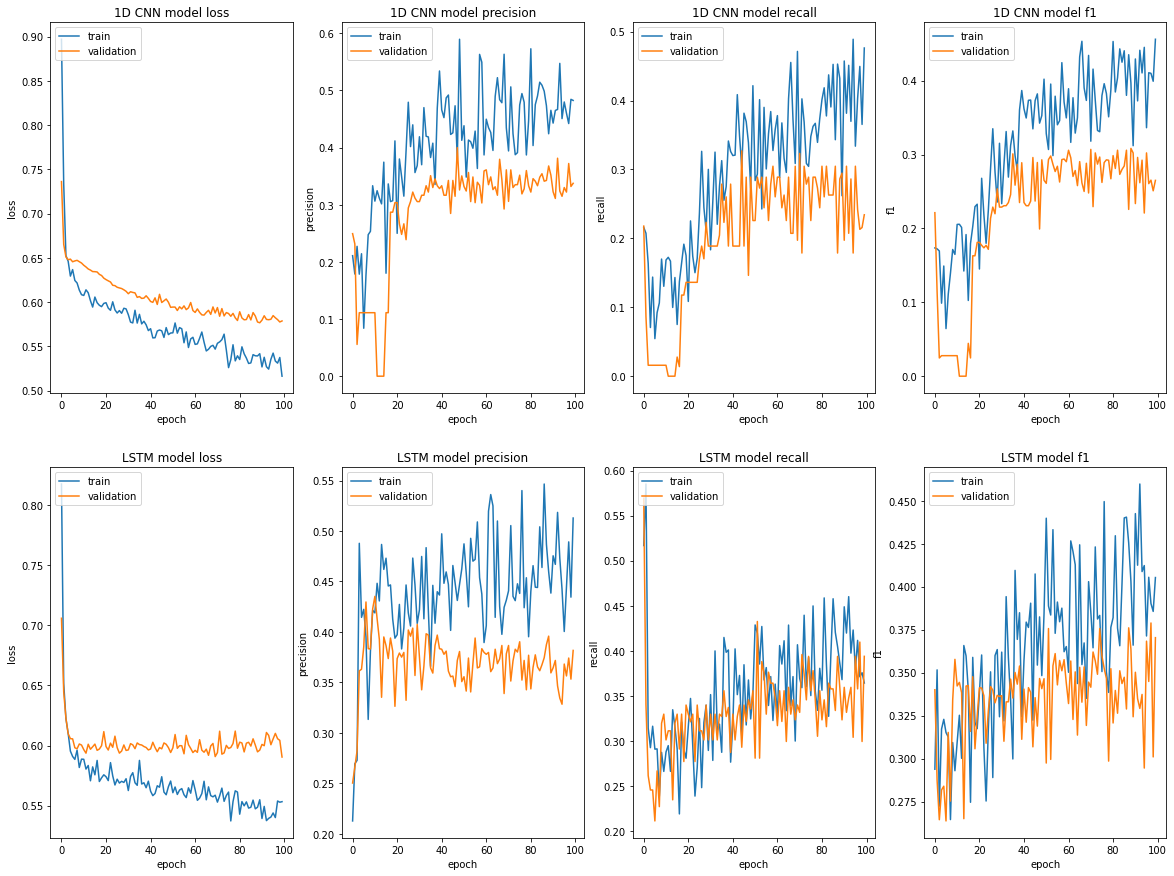

In [ ]:
fig,((ax11,ax12,ax13,ax14),(ax21,ax22,ax23,ax24)) = plt.subplots(2,4,figsize=(20,15))
ax11.plot(hist.history['loss'])
ax11.plot(hist.history['val_loss'])
ax11.title.set_text('1D CNN model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(hist.history['precision_m'])
ax12.plot(hist.history['val_precision_m'])
ax12.set_title('1D CNN model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(hist.history['recall_m'])
ax13.plot(hist.history['val_recall_m'])
ax13.set_title('1D CNN model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(hist.history['f1_m'])
ax14.plot(hist.history['val_f1_m'])
ax14.set_title('1D CNN model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')


ax21.plot(hist2.history['loss'])
ax21.plot(hist2.history['val_loss'])
ax21.title.set_text('LSTM model loss')
ax21.set_ylabel('loss')
ax21.set_xlabel('epoch')
ax21.legend(['train', 'validation'], loc='upper left')

ax22.plot(hist2.history['precision_m'])
ax22.plot(hist2.history['val_precision_m'])
ax22.set_title('LSTM model precision')
ax22.set_ylabel('precision')
ax22.set_xlabel('epoch')
ax22.legend(['train', 'validation'], loc='upper left')

ax23.plot(hist2.history['recall_m'])
ax23.plot(hist2.history['val_recall_m'])
ax23.set_title('LSTM model recall')
ax23.set_ylabel('recall')
ax23.set_xlabel('epoch')
ax23.legend(['train', 'validation'], loc='upper left')

ax24.plot(hist2.history['f1_m'])
ax24.plot(hist2.history['val_f1_m'])
ax24.set_title('LSTM model f1')
ax24.set_ylabel('f1')
ax24.set_xlabel('epoch')
ax24.legend(['train', 'validation'], loc='upper left')



In [ ]:
from rasterio.plot import reshape_as_raster,reshape_as_image
src = rasterio.open('/content/drive/MyDrive/MyinGyan_corn/evi_data_cube.tif')
# src = rasterio.open('/content/drive/MyDrive/MyinGyan_corn/training_image_aywd_21 (1).tif')
# src = rasterio.open('/content/drive/MyDrive/Data_extractor/AYWD_area.tif')
img = src.read()   # load our original input file bands to a numby array stack
print(img.shape)
reshaped_img=reshape_as_image(img)
reshaped_img=reshaped_img.reshape(-1,reshaped_img[2].shape[1])
print(reshaped_img.shape)
reshaped_img = np.nan_to_num(reshaped_img)


(34, 1960, 2335)
(4576600, 34)


143019/143019 [==============================] - 404s 3ms/step
(4576600,)
Reshaped Image shape :(1960, 2335)


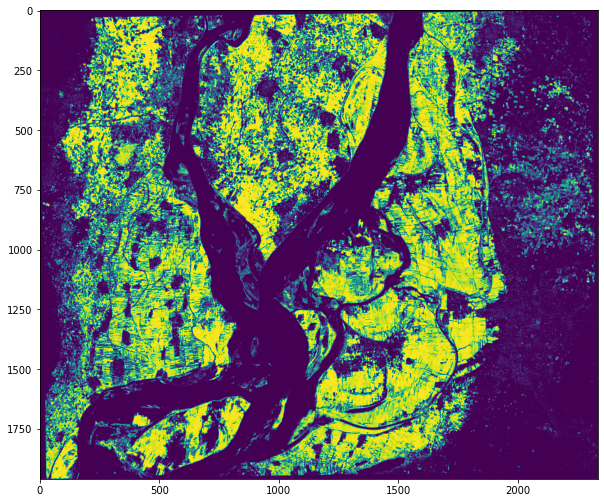

In [ ]:
pred_1D = np.squeeze(model.predict(reshaped_img,verbose=1))
print(pred_1D.shape)
pred_1D = pred_1D.reshape(img.shape[1],img.shape[2])
print(f'Reshaped Image shape :{pred_1D.shape}')
plt.figure(figsize=(10,10))
plt.imshow(pred_1D)

In [ ]:
# import tifffile as tfl 
# y = tfl.imread('/content/label_mask.tif')
# y_pred = pred_1D
# print(f'Terrasphere Data shape {y.shape}')
# print(f'Predicted Data Shape{y_pred.shape}')

# y_pred[y_pred>0.5]=1
# y_pred[y_pred<0.5]=0

# y_pred = y_pred.astype(float)


# fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,15))
# ax1.imshow(y)
# ax1.set_title('label mask')
# ax2.imshow(y_pred)
# ax2.set_title('Predictions')

# y_flat = np.expand_dims(y.flatten(),1)
# y_pred_flat=np.expand_dims(y_pred.flatten(),1)

# print(y_flat.shape)
# print(y_pred_flat.shape)

In [ ]:
# from sklearn.metrics import confusion_matrix,classification_report
# label= "Classification report of Myingyan corn"
# print(label)
# print(classification_report(y_flat,y_pred_flat))

In [ ]:
# data_set = '/content/drive/MyDrive/AyeYarWaddy_Corn_Detection/training_image_ayeyarwaddy.tif'
# data_set = '/content/drive/MyDrive/AyeYarWaddy_Corn_Detection/training_image_delta.tif'
# data_set = '/content/drive/MyDrive/AyeYarWaddy_Corn_Detection/training_image_ayeyarwaddy2.tif'
# data_set = '/content/drive/MyDrive/Data_extractor/AYWD_area.tif'
# data_set = '/content/drive/MyDrive/MyinGyan_corn/training_image_kanma.tif'
# data_set ='/content/drive/MyDrive/MyinGyan_corn/training_image_aywd_21 (1).tif'

In [ ]:
data_set = '/content/drive/MyDrive/MyinGyan_corn/training_image_bago.tif'

(94, 626, 816)
(626, 816, 34)
(34, 626, 816)
(34, 626, 816)
(510816, 34)
15963/15963 [==============================] - 46s 3ms/step
(510816,)
Reshaped Image shape :(626, 816)


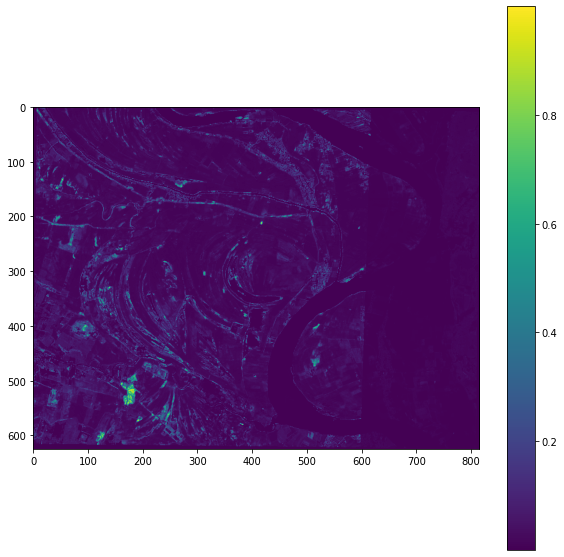

In [ ]:
src = rasterio.open(data_set)
img = src.read()   # load our original input file bands to a numby array stack
print(img.shape)


training_img = np.zeros((img.shape[1],img.shape[2],34))
img_arr = img
dims = 34
#Adding input image into trainign image
for i in range(31):
    training_img[:,:,i]= img_arr[i]
print(training_img.shape)
training_img = np.moveaxis(training_img,2,0)
print(training_img.shape)

from rasterio.plot import reshape_as_raster,reshape_as_image
#src1=  rasterio.open('/content/drive/MyDrive/MyinGyan_corn/evi_data_cube.tif')
#image = src.read()
print(training_img.shape)
reshaped_img=reshape_as_image(training_img)
reshaped_img=reshaped_img.reshape(-1,reshaped_img[2].shape[1])
print(reshaped_img.shape)
reshaped_img = np.nan_to_num(reshaped_img)


pred_1D = np.squeeze(model.predict(reshaped_img,verbose=1))
print(pred_1D.shape)
pred_1D = pred_1D.reshape(img.shape[1],img.shape[2])
print(f'Reshaped Image shape :{pred_1D.shape}')
plt.figure(figsize=(10,10))
plt.imshow(pred_1D)
plt.colorbar()

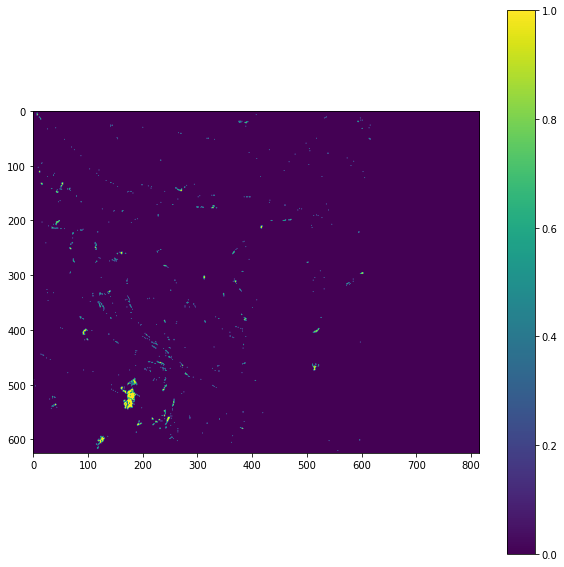

In [ ]:
pred_1D[pred_1D>0.5]=1
pred_1D[pred_1D<=0.5]=0
plt.figure(figsize=(10,10))
plt.imshow(pred_1D>=0.2)
plt.colorbar()


In [ ]:
import tifffile as tfl
tfl.imsave('/content/Predictions/1D_cnn_pred_myingyan_21.tif',pred_1D)

# ref_img = '/content/drive/MyDrive/AyeYarWaddy_Corn_Detection/training_image_ayeyarwaddy2.tif'
ref_img = '/content/drive/MyDrive/MyinGyan_corn/training_image_aywd_21 (1).tif'

from osgeo import gdal

ds =gdal.Open(ref_img)
gt = ds.GetGeoTransform()
prof = ds.GetProjection()

driver = gdal.GetDriverByName("GTiff")
driver.Register()
# outds = driver.Create("/content/GeoRef_pred/1D_cnn_pred.tif",xsize=img.shape[2], ysize =img.shape[1], bands=1,eType=gdal.GDT_CFloat32 )
outds = driver.Create("/content/Predictions/1D_CNN__myingyan_21_pred_final.tif",xsize=img.shape[2], ysize =img.shape[1], bands=1,eType=gdal.GDT_CFloat32 ) #Enable this if you are saving LSTM
outds.SetGeoTransform(gt)
outds.SetProjection(prof)
outband =outds.GetRasterBand(1)
outband.WriteArray(pred_1D) #Saving 1D CNN predictions as geotiff result
#outband.WriteArray(pred_LSTM) #Saving 1D CNN predictions as geotiff result

outband =None
outds=None

(70, 1353, 1419)


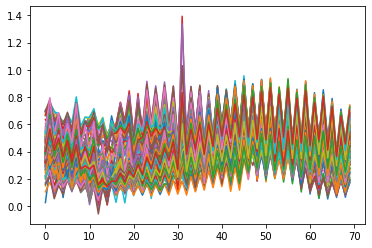

In [ ]:
print(img_arr.shape)
plt.plot(img_arr[:,:,2]);

In [ ]:
train_pts.plot()

(8974, 34)


Text(0.5, 1.0, 'Ayeyarwaddy spectrum')

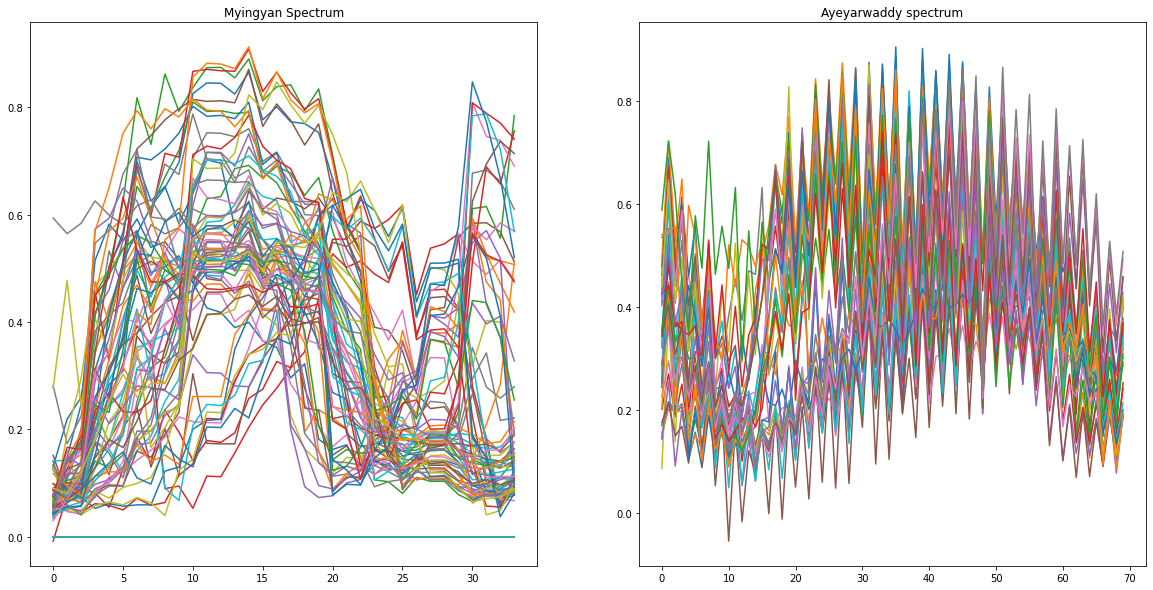

In [ ]:

benchmark =train_pts.loc[train_pts['RASTERVALU'] == 1]
benchmark= benchmark[bands].values
print(benchmark.shape)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.plot(benchmark[:100].T);
ax1.set_title('Myingyan Spectrum')
ax2.plot(img_arr[:,:,0]);
ax2.set_title('Ayeyarwaddy spectrum')

# plt.plot(x_t[:,100:200]);

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(pred_1D)
plt.colorbar()

In [ ]:
!unzip -u "/content/DL_1DCNN_LSTM_weights.zip" -d "/content/DL_1DCNN_LSTM_weights"

In [ ]:
weights = '/content/DL_1DCNN_LSTM_weights/content/1D_CNN&LSM trained Weights/1D_CNN_model.h5'

In [ ]:
#Metrics 
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model=keras.models.load_model(weights,
                                 custom_objects={ 'bce_dice_loss': bce_dice_loss, 
                                                  'dice_coef':dice_coef,
                                                 'f1_m':f1_m,
                                                 'precision_m':precision_m,
                                                 'recall_m':recall_m} )

In [ ]:
training_img = np.zeros((1239, 1088,34))
img_arr = img

In [ ]:
img_arr.shape,training_img.shape

In [ ]:
dims = 34
#Adding input image into trainign image
for i in range(31):
    training_img[:,:,i]= img_arr[i]
print(training_img.shape)

In [ ]:
img.shape

In [ ]:
print(training_img.shape)
training_img = np.moveaxis(training_img,2,0)
print(training_img.shape)

In [ ]:
from rasterio.plot import reshape_as_raster,reshape_as_image
#src1=  rasterio.open('/content/drive/MyDrive/MyinGyan_corn/evi_data_cube.tif')
#image = src.read()
print(training_img.shape)
reshaped_img=reshape_as_image(training_img)
reshaped_img=reshaped_img.reshape(-1,reshaped_img[2].shape[1])
print(reshaped_img.shape)
reshaped_img = np.nan_to_num(reshaped_img)

In [ ]:
pred_1D = np.squeeze(model.predict(reshaped_img,verbose=1))


In [ ]:
print(pred_1D.shape)
pred_1D = pred_1D.reshape(img.shape[1],img.shape[2])
print(f'Reshaped Image shape :{pred_1D.shape}')

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(pred_1D>=0.9)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(pred_1D)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(pred_1D>=0.9)

In [ ]:
!zip -r '/content/Predictions.zip' '/content/Predictions'

  adding: content/Predictions/ (stored 0%)
  adding: content/Predictions/1D_cnn_pred_bago.tif (deflated 97%)
  adding: content/Predictions/1D_CNN__bago_pred_final.tif (deflated 98%)
  adding: content/Predictions/1D_CNN_pred_final.tif (deflated 98%)
  adding: content/Predictions/1D_cnn_pred_ayeyarwaddy.tif (deflated 98%)
  adding: content/Predictions/1D_CNN__kanma_pred_final.tif (deflated 99%)
  adding: content/Predictions/1D_cnn_pred_kanma.tif (deflated 98%)
  adding: content/Predictions/1D_cnn_pred.tif (deflated 97%)
  adding: content/Predictions/1D_CNN__ayeyarwaddy_pred_final.tif (deflated 99%)
